## Dataset Prueba 1 - Tesis Javier-Uriel

### Importamos algunas librerías que nos serán útiles más adelante

In [1]:
import os
import time
import random

import pandas as pd # for dataframe operations. 
import numpy as np #for linear algebra operations.
import seaborn as sns # data visualization library
import matplotlib.pyplot as plt # for plotting

from scipy.fftpack import fft, fftfreq

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf

pd.set_option('display.max_columns', None) #Para mostrar todas las columnas
random.seed(1)

### Leemos el Dataset

In [2]:
#Dataset solo movimientos en Z
rpm_list = ['RPM0', 'RPM1', 'RPM2', 'RPM3']
states_list_org = ["vz","az", "uvz", 
                    "p", "q",
                    "wp", "wq", 
                    "ap", "aq"]
#states_list_org = ["vz","az", "uvz"]
states_list_min = ["vz","az", "uvz"]
dataset_name = "Dataset_Z7_Disturbance_Z"
directory = "../logs/Datasets/"+dataset_name
ORDER = 3
dfs = []
states_list=states_list_org.copy()

### Corregir la salida 
El estado que entrega Pybullet de RPMs es la salida anterior, en este dataset se tomará RPMs como la salida actual. Si el primer elemento de RPMs es 0, es necesario hacer el shift

In [3]:
for filename in os.listdir(directory):
    if not filename.endswith(".csv"):
        continue
    df = pd.read_csv(os.path.join(directory, filename))
    if any(df['z']<=1) or any(abs(df['vz'])>=10): #Eliminar si el dron se cae
        print(filename)
    else:
        if any(df[rpm_list].loc[0]==0): #Desplazar los estados de RPM si es necesario
            df[rpm_list] = df[rpm_list].shift(periods=-1)
            df = df.dropna()
            df.to_csv(os.path.join(directory, filename), index=False)

        a = []
        ## Desplazamos estados anteriores        
        for n in range(1,ORDER+1):
            for column in states_list:
                df[column+str(n)] = df[column].shift(periods=n, fill_value=0)
                a.append(column+str(n))
        dfs.append(df)
states_list+=a        
        
dataset = pd.concat(dfs)
dataset.describe()

,timestamps,x,y,z,Q1,Q2,Q3,Q4,p,q,r,vx,vy,vz,wp,wq,wr,ax,ay,az,ap,aq,ar,RPM0,RPM1,RPM2,RPM3,ux,uy,uz,uvx,uvy,uvz,up,uq,ur,uwp,uwq,uwr,vz1,az1,uvz1,p1,q1,wp1,wq1,ap1,aq1,vz2,az2,uvz2,p2,q2,wp2,wq2,ap2,aq2,vz3,az3,uvz3,p3,q3,wp3,wq3,ap3,aq3
count,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4007833.0,4007833.0,4007833.0,4007833.0,4007833.0,4.007833e+06,4007833.0,4007833.0,4007833.0,4007833.0,4007833.0,4007833.0,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06
mean,4.999583e+01,1.232111e-01,-1.129199e-01,5.341394e+01,-1.124056e-04,-1.166851e-04,6.719640e-05,9.999114e-01,-2.303242e-04,-2.300284e-04,1.836237e-04,1.468863e-03,-1.370043e-03,7.058128e-02,6.759972e-05,-6.813699e-05,-4.751161e-05,1.580413e-10,1.229393e-09,3.210177e-04,-4.129174e-08,-1.073950e-09,-1.275564e-09,1.441872e+04,1.441844e+04,1.441873e+04,1.441900e+04,0.0,0.0,50.0,0.0,0.0,5.302769e-02,0.0,0.0,0.0,0.0,0.0,0.0,7.057994e-02,3.228008e-04,5.302917e-02,-2.303242e-04,-2.300284e-04,6.759989e-05,-6.813698e-05,-4.142293e-08,-1.133661e-09,7.057859e-02,3.245846e-04,5.303064e-02,-2.303243e-04,-2.300284e-04,6.760007e-05,-6.813698e-05,-4.155414e-08,-1.193382e-09,7.057724e-02,3.263690e-04,5.303212e-02,-2.303243e-04,-2.300284e-04,6.760024e-05,-6.813697e-05,-4.168538e-08,-1.253112e-09
std,2.886631e+01,8.825598e-02,8.576300e-02,9.609585e+00,9.626432e-03,9.127336e-03,8.662359e-04,6.002488e-04,1.938697e-02,1.821034e-02,2.268712e-03,2.554577e-02,2.691607e-02,8.876363e-01,1.312313e-01,1.266916e-01,1.608981e-02,1.428626e-01,1.522444e-01,1.822109e+00,2.016054e+00,1.990444e+00,6.490893e-01,1.325549e+03,1.328543e+03,1.325717e+03,1.322718e+03,0.0,0.0,0.0,0.0,0.0,9.432127e-01,0.0,0.0,0.0,0.0,0.0,0.0,8.876180e-01,1.822077e+00,9.431880e-01,1.938697e-02,1.821034e-02,1.312313e-01,1.266916e-01,2.016054e+00,1.990444e+00,8.875997e-01,1.822046e+00,9.431632e-01,1.938697e-02,1.821034e-02,1.312313e-01,1.266916e-01,2.016054e+00,1.990444e+00,8.875814e-01,1.822014e+00,9.431385e-01,1.938697e-02,1.821034e-02,1.312313e-01,1.266916e-01,2.016054e+00,1.990444e+00
min,0.000000e+00,-2.047597e-01,-4.811760e-01,2.697847e+01,-1.698321e-01,-1.457588e-01,-4.432610e-02,9.752161e-01,-3.536326e-01,-2.834447e-01,-8.505308e-02,-4.256045e-01,-5.883179e-01,-9.426658e+00,-2.441203e+00,-2.568337e+00,-6.203632e-01,-4.023462e+00,-3.135487e+00,-9.800000e+00,-1.762474e+01,-1.727289e+01,-1.572234e+01,9.440300e+03,9.440300e+03,9.440300e+03,9.440300e+03,0.0,0.0,50.0,0.0,0.0,-9.640079e+00,0.0,0.0,0.0,0.0,0.0,0.0,-9.426658e+00,-9.800000e+00,-9.640079e+00,-3.536326e-01,-2.834447e-01,-2.441203e+00,-2.568337e+00,-1.762474e+01,-1.727289e+01,-9.426658e+00,-9.800000e+00,-9.640079e+00,-3.536326e-01,-2.834447e-01,-2.441203e+00,-2.568337e+00,-1.762474e+01,-1.727289e+01,-9.426658e+00,-9.800000e+00,-9.640079e+00,-3.536326e-01,-2.834447e-01,-2.441203e+00,-2.568337e+00,-1.762474e+01,-1.727289e+01
25%,2.499583e+01,7.730229e-02,-1.592710e-01,5.008806e+01,-3.020625e-08,-2.448411e-08,-5.146146e-07,1.000000e+00,-6.436319e-08,-5.447548e-08,-9.294998e-07,-5.306351e-08,-8.073925e-08,-7.346576e-02,-4.127837e-07,-3.408623e-07,-3.469616e-07,-4.160205e-07,-5.834920e-07,-7.146616e-03,-3.930490e-06,-3.317791e-06,-1.070975e-09,1.442594e+04,1.442414e+04,1.442605e+04,1.442492e+04,0.0,0.0,50.0,0.0,0.0,-7.237447e-02,0.0,0.0,0.0,0.0,0.0,0.0,-7.344996e-02,-7.143027e-03,-7.237447e-02,-6.435992e-08,-5.447285e-08,-4.127670e-07,-3.408300e-07,-3.930290e-06,-3.317570e-06,-7.34

### Estados repetidos

En este caso se eliminan estados repetidos y estados que se encuentren en estado transitorio mientras el dron despega o se estabiliza antes de introducir la señal de control.

In [4]:
shape_b4 = dataset.drop(["timestamps"], axis=1).shape
shape_drop= dataset.drop(["timestamps"], axis=1).drop_duplicates().shape
print(f'shape (b4 drop) = {shape_b4}')
print(f'shape = {shape_drop}')
print(f'len (b4 drop) - len = {shape_b4[0]-shape_drop[0]}')

shape (b4 drop) = (4007833, 65)
shape = (3991268, 65)
len (b4 drop) - len = 16565


In [5]:
states = dataset.drop(["timestamps"], axis=1).drop_duplicates()[states_list]
print(f'columns = {states.columns}')
print(f'shape = {states.shape}')
states.head()

columns = Index(['vz', 'az', 'uvz', 'p', 'q', 'wp', 'wq', 'ap', 'aq', 'vz1', 'az1',
       'uvz1', 'p1', 'q1', 'wp1', 'wq1', 'ap1', 'aq1', 'vz2', 'az2', 'uvz2',
       'p2', 'q2', 'wp2', 'wq2', 'ap2', 'aq2', 'vz3', 'az3', 'uvz3', 'p3',
       'q3', 'wp3', 'wq3', 'ap3', 'aq3'],
      dtype='object')
shape = (3991268, 36)


,vz,az,uvz,p,q,wp,wq,ap,aq,vz1,az1,uvz1,p1,q1,wp1,wq1,ap1,aq1,vz2,az2,uvz2,p2,q2,wp2,wq2,ap2,aq2,vz3,az3,uvz3,p3,q3,wp3,wq3,ap3,aq3
0,-0.040833,-9.800000,-0.994789,0.0,-0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.064276,-5.626198,-0.994789,0.0,-0.0,0.0,0.0,0.0,0.0,-0.040833,-9.800000,-0.994789,0.0,-0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.087714,-5.625162,-0.994789,0.0,-0.0,0.0,0.0,0.0,0.0,-0.064276,-5.626198,-0.994789,0.0,-0.0,0.0,0.0,0.0,0.0,-0.040833,-9.800000,-0.994789,0.0,-0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.111148,-5.624082,-0.994789,0.0,-0.0,0.0,0.0,0.0,0.0,-0.087714,-5.625162,-0.994789,0.0,-0.0,0.0,0.0,0.0,0.0,-0.064276,-5.626198,-0.994789,0.0,-0.0,0.0,0.0,0.0,0.0,-0.040833,-9.800000,-0.994789,0.0,-0.0,0.0,0.0,0.0,0.0
4,-0.134577,-5.622958,-0.994789,0.0,-0.0,0.0,0.0,0.0,0.0,-0.111148,-5.624082,-0.994789,0.0,-0.0,0.0,0.0,0.0,0.0,-0.087714,-5.625162,-0.994789,0.0,-0.0,0.0,0.0,0.0,0.0,-0.064276,-5.626198,-0.994789,0.0,-0.0,0.0,0.0,0.0,0.0


In [6]:
states_duplicates = dataset[dataset.duplicated(keep='last')]
states_duplicates = states_duplicates.dropna()

Text(0.5, 0, 't')

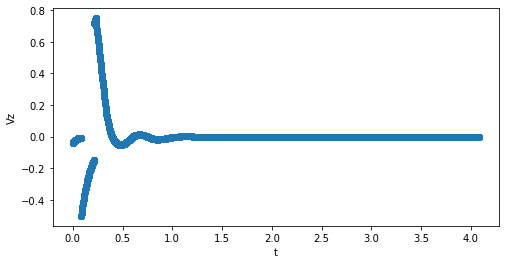

In [7]:
fig = plt.figure(figsize=(8, 4))
t = states_duplicates['timestamps']
y = states_duplicates['vz']
#y_ref = states_duplicates['uvz']
plt.scatter(t, y)
#plt.scatter(t, y_ref)
plt.ylabel('Vz')
plt.xlabel('t')

In [8]:
#Eliminar del dataset los estados repetidos entre 20 y 25 segundos
# for filename in os.listdir(directory):
#     if not filename.endswith(".csv"):
#         continue
#     df = pd.read_csv(os.path.join(directory, filename))
#     df = df[(df['timestamps']>20) & (df['timestamps']<25)]
#     df = pd.concat([df, states_duplicates])
#     df = df.reset_index(drop=True)
#     df_gpby = df.groupby(list(df.columns))
#     idx = [x[0] for x in df_gpby.groups.values() if len(x) > 1]
#     if len(idx)>1:
#         print(filename)

In [27]:
df = pd.read_csv(os.path.join(directory, filename))
df = df[df['timestamps']>5]
df.describe()

,timestamps,x,y,z,Q1,Q2,Q3,Q4,p,q,r,vx,vy,vz,wp,wq,wr,ax,ay,az,ap,aq,ar,RPM0,RPM1,RPM2,RPM3,ux,uy,uz,uvx,uvy,uvz,up,uq,ur,uwp,uwq,uwr
count,22798.000000,22798.000000,22798.000000,22798.000000,2.279800e+04,2.279800e+04,2.279800e+04,22798.000000,2.279800e+04,2.279800e+04,2.279800e+04,2.279800e+04,2.279800e+04,2.279800e+04,2.279800e+04,2.279800e+04,2.279800e+04,2.279800e+04,2.279800e+04,2.279800e+04,2.279800e+04,2.279800e+04,2.279800e+04,22798.000000,22798.000000,22798.000000,22798.000000,22798.0,22798.0,22798.0,22798.0,22798.0,22798.000000,22798.0,22798.0,22798.0,22798.0,22798.0,22798.0
mean,52.497917,0.213963,-0.068708,55.416453,1.019881e-05,-2.320382e-04,9.037240e-06,0.999945,2.006849e-05,-4.642801e-04,2.291110e-05,1.300307e-03,-2.803249e-04,1.335566e-01,-1.313905e-06,-1.886191e-05,-1.271132e-05,6.285314e-10,-5.870805e-10,-3.188818e-03,-3.140801e-11,3.281040e-10,-6.926576e-09,14441.107336,14441.075299,14441.351558,14441.298640,0.0,0.0,50.0,0.0,0.0,0.131265,0.0,0.0,0.0,0.0,0.0,0.0
std,27.422334,0.043195,0.028817,3.834429,6.088466e-03,8.567149e-03,2.470256e-04,0.000316,1.220149e-02,1.713959e-02,6.116206e-04,2.215137e-02,1.357079e-02,2.172434e-01,8.523745e-02,1.224003e-01,9.954016e-03,1.340132e-01,8.120165e-02,1.274944e+00,1.735954e+00,2.012493e+00,5.720721e-01,960.019748,960.261655,956.145917,957.229090,0.0,0.0,0.0,0.0,0.0,0.218392,0.0,0.0,0.0,0.0,0.0,0.0
min,5.004167,0.088270,-0.118016,50.934390,-5.899855e-02,-8.674468e-02,-4.739497e-03,0.994740,-1.183712e-01,-1.739674e-01,-8.335807e-03,-1.534390e-01,-1.178540e-01,-4.953729e-01,-9.540215e-01,-1.603630e+00,-2.390957e-01,-1.608419e+00,-7.039856e-01,-5.787428e+00,-1.443714e+01,-1.487096e+01,-1.131256e+01,9440.300000,9440.300000,9440.300000,9440.300000,0.0,0.0,50.0,0.0,0.0,-0.064605,0.0,0.0,0.0,0.0,0.0,0.0
25%,28.751042,0.211788,-0.087524,52.904067,-6.527895e-09,-3.140996e-09,-8.093747e-07,1.000000,-1.305053e-08,-7.470571e-09,-1.617737e-06,-5.113449e-09,-2.509279e-08,1.472631e-10,-7.158308e-08,-5.050098e-08,5.433390e-09,-4.999248e-08,-9.614242e-08,-2.287605e-04,-1.078042e-06,-3.351743e-07,-3.852363e-10,14467.434927,14467.388137,14467.379223,14467.464329,0.0,0.0,50.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
50%,52.497917,0.228379,-0.072161,53.091472,-1.585926e-19,-6.733801e-19,-4.048744e-07,1.000000,1.169691e-18,-1.902632e-18,-8.089894e-07,-2.123666e-16,2.307827e-16,2.113164e-03,-1.919636e-18,-1.031927e-17,6.819486e-09,1.444813e-17,1.766049e-18,2.259443e-10,-5.724179e-15,1.086454e-17,-5.890096e-11,14468.433843,14468.449513,14468.440113,14468.442277,0.0,0.0,50.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
75%,76.244792,0.249480,-0.033927,58.664362,4.187087e-09,2.848567e-09,-3.331377e-07,1.000000,1.028379e-08,6.152859e-09,-6.657199e-07,9.294044e-09,8.371144e-09,2.162954e-01,8.847403e-08,4.176720e-08,1.376374e-08,7.261314e-08,1.174926e-07,1.846656e-04,8.160492e-07,8.864161e-07,3.187153e-09,14488.003924,14487.611471,14486.691633,14486.832130,0.0,0.0,50.0,0.0,0.0,0.216864,0.0,0.0,0.0,0.0,0.0,0.0
max,99.991667,0.262985,-0.017267,63.877639,8.686141e-02,8.197384e-02,4.244254e-03,1.000000,1.740110e-01,1.641319e-01,8.578684e-03,2.634841e-01,1.226969e-01,1.531939e+00,1.021935e+00,1.240884e+00,2.399215e-01,1.464879e+00,8.113460e-01,1.217651e+01,1.605764e+01,1.668113e+01,1.152098e+01,21666.447500,21666.447500,21666.447500,21666.447500,0.0,0.0,50.0,0.0,0.0,0.704802,0.0,0.0,0.0,0.0,0.0,0.0


### Se grafican los datos

Se grafica un histograma de cada una de las propiedades los datos analizados individualmente por columnas, en el cual se observa que todos tienen distribuciones altamente apuntadas (curosis) y en algunos casos bimodales, pero de cualquier manera, no son uniformes

In [10]:
n_bins = 50
#_ = dataset.hist(bins=n_bins, figsize=(30,30))

### Análisis de estados

Text(0.5, 0, 'Error Vz')

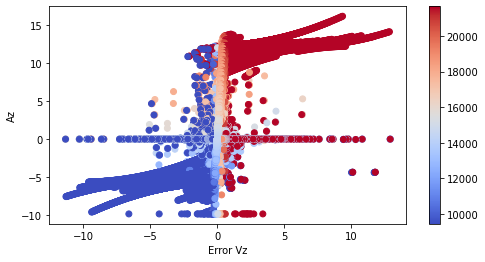

In [11]:
fig = plt.figure(figsize=(8, 4))
x = dataset['uvz']-dataset['vz']
y = dataset['az']
c = dataset['RPM0']
plt.scatter(x, y, c=c, cmap='coolwarm')
plt.colorbar()
plt.ylabel('Az')
plt.xlabel('Error Vz')

Text(0.5, 0, 'Vz')

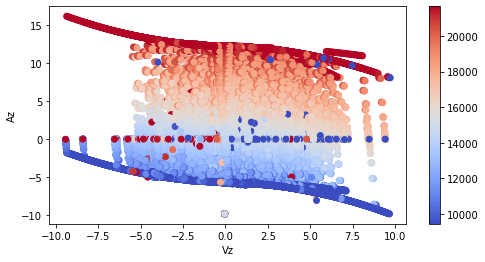

In [12]:
fig = plt.figure(figsize=(8, 4))
x = dataset['vz']
plt.scatter(x, y, c=c, cmap='coolwarm')
plt.colorbar()
plt.ylabel('Az')
plt.xlabel('Vz')

### Análisis de Fourier

#### Gráfica de algunas señales

In [13]:
def plot_fourier(df, states=['vz', 'uvz', 'az']):
    dt = df['timestamps'][1]-df['timestamps'][0]
    n = len(df['timestamps'])
    Y = fft(df[states[0]].to_numpy()) / n # Transformada normalizada
    Y_ref = fft(df[states[1]].to_numpy()) / n
    frq = fftfreq(n, dt)
    fig = plt.figure(figsize=(14, 10))
    ax1 = fig.add_subplot(221)
    ax1.plot(df['timestamps'], df[states[0]], df['timestamps'], df[states[1]])
    ax1.set_xlabel('Tiempo (s)')
    ax1.set_ylabel('$y(t)$')
    ax1.set_title('Señal en el tiempo (Vz y ref)')
    ax2 = fig.add_subplot(223)
    ax2.set_title('Señal en frecuencia (Vz y ref)')
    ax2.vlines(frq[0:int(n/10)], 0, abs(Y[0:int(n/10)]))
    ax2.vlines(frq[0:int(n/10)], 0, abs(Y_ref[0:int(n/10)]),  color='orange')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Abs($Y$)')

    Y = fft(df[states[2]].to_numpy()) / n # Transformada normalizada
    ax1 = fig.add_subplot(222)
    ax1.plot(df['timestamps'], df[states[2]])
    ax1.set_xlabel('Tiempo (s)')
    ax1.set_ylabel('$y(t)$')
    ax1.set_title('Señal en tiempo (az)')
    ax2 = fig.add_subplot(224)
    ax2.set_title('Señal en frecuencia (az)')
    ax2.vlines(frq[0:int(n/10)], 0, abs(Y[0:int(n/10)]))
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Abs($Y$)')

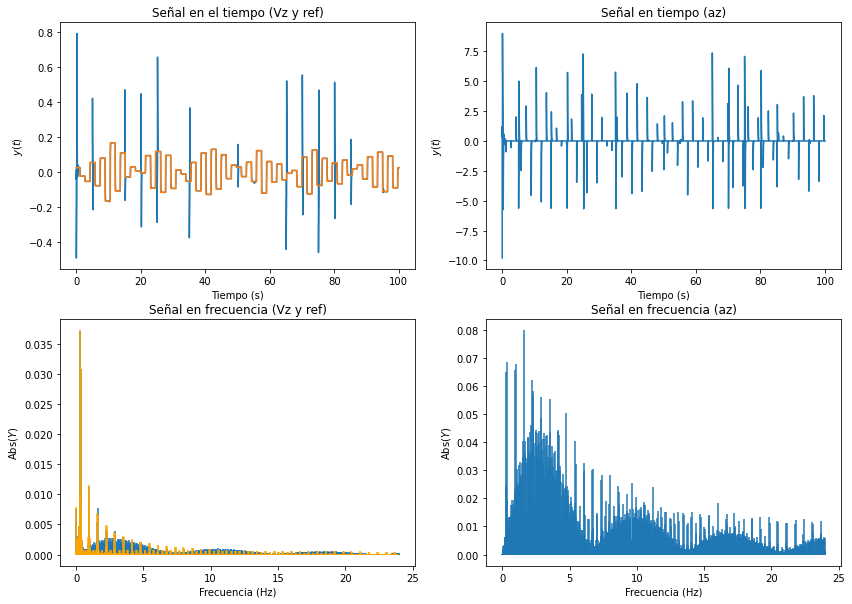

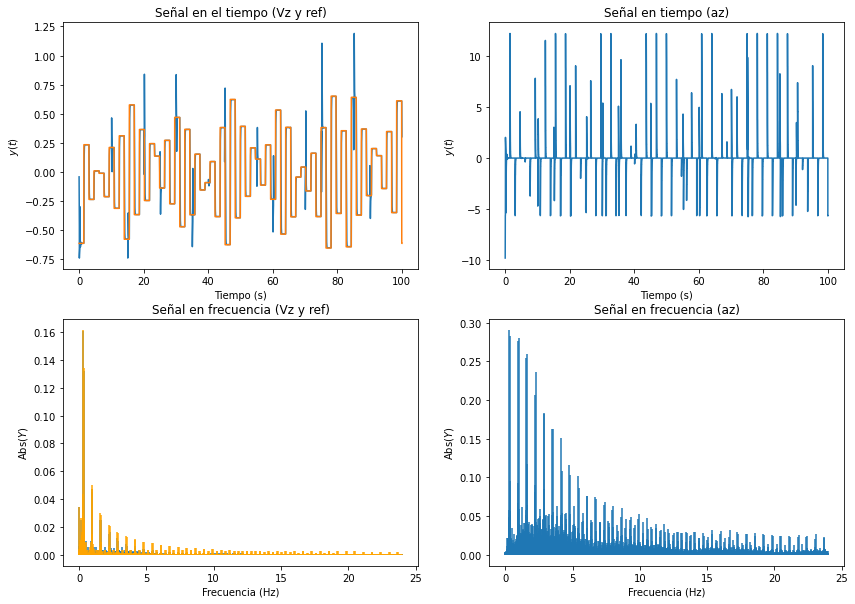

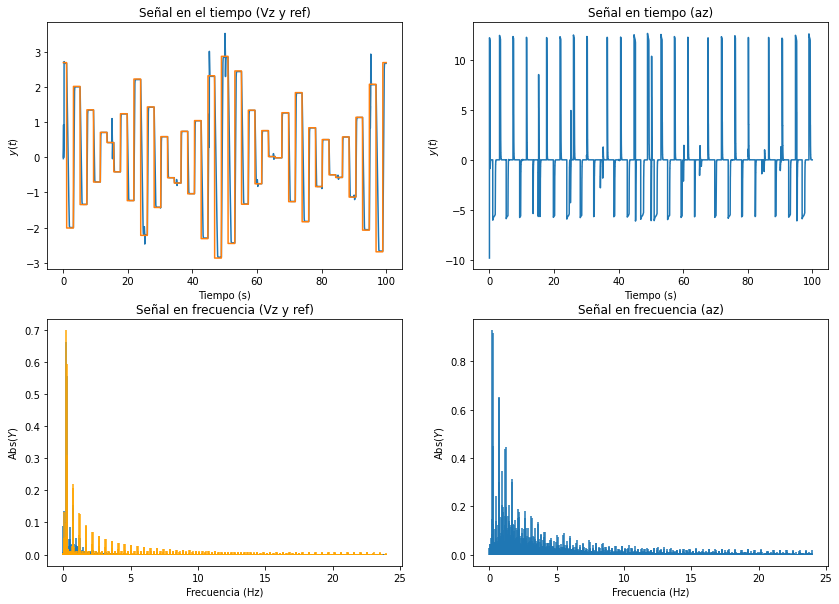

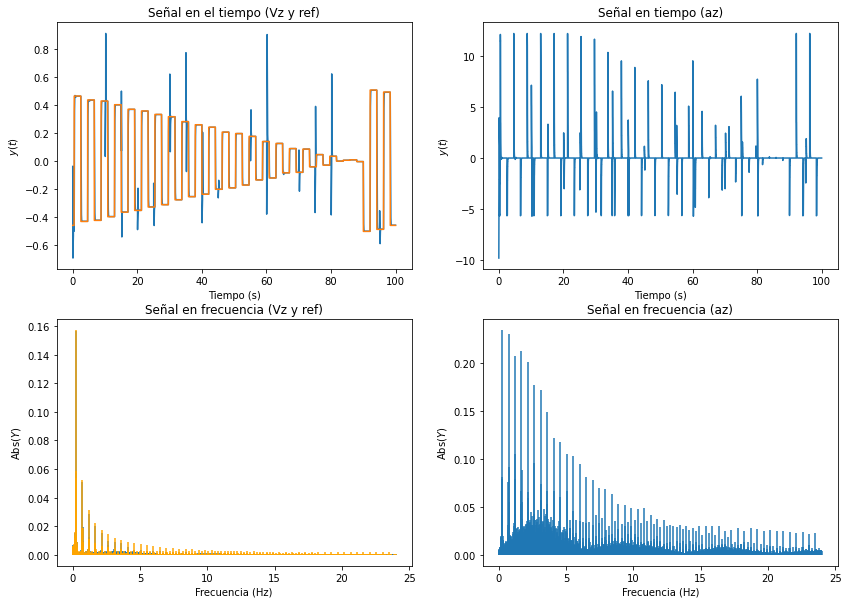

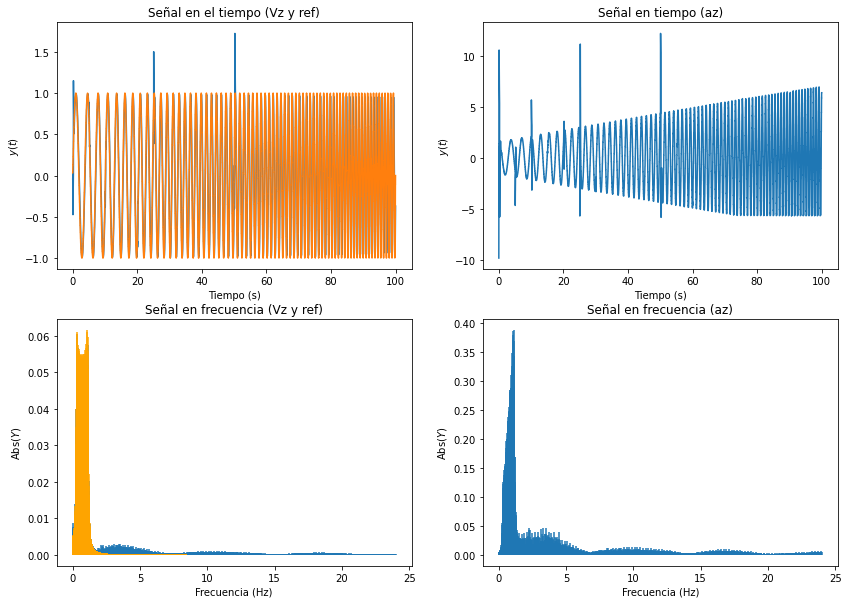

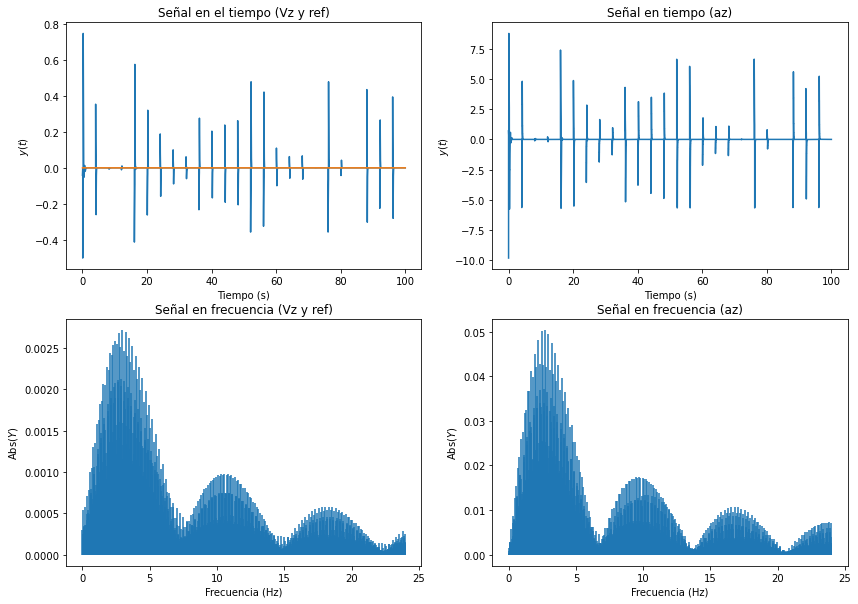

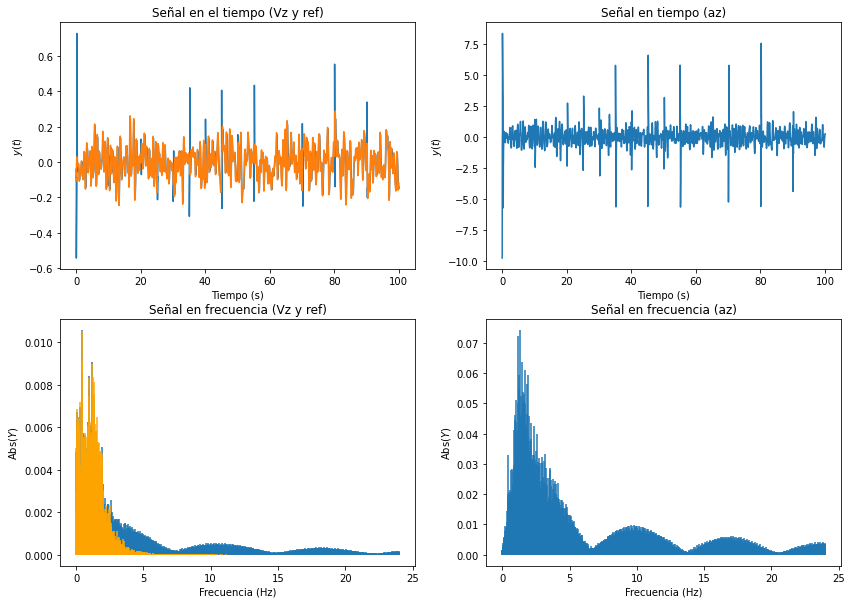

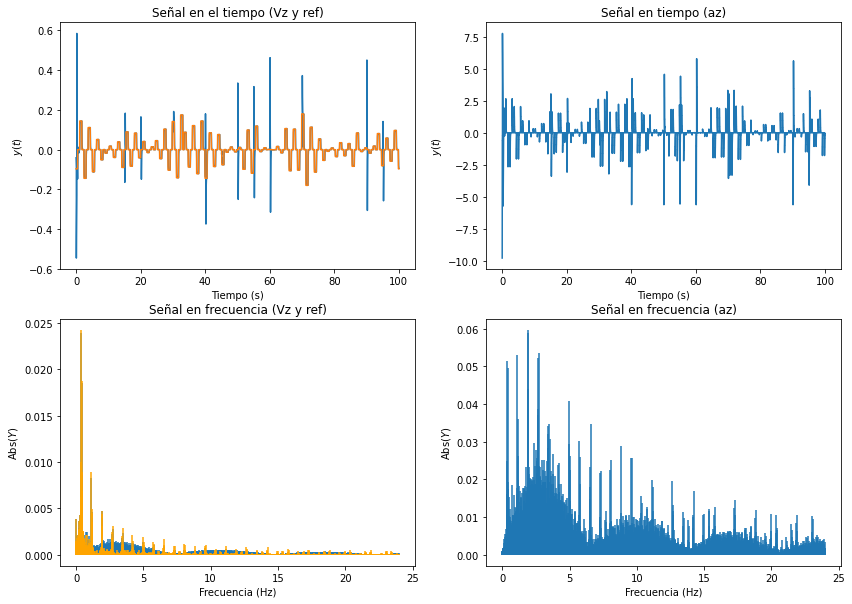

In [14]:
for df in random.choices(dfs, k = 8):
    plot_fourier(df)

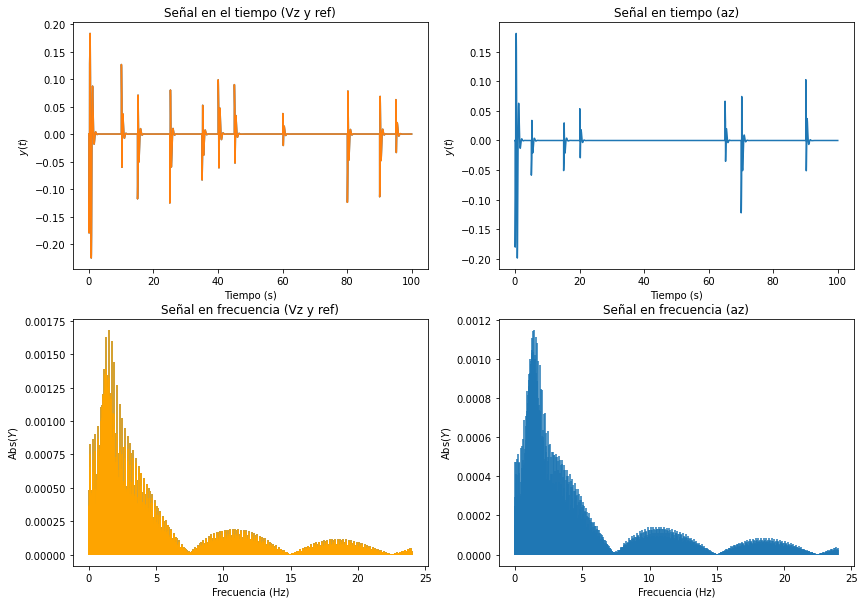

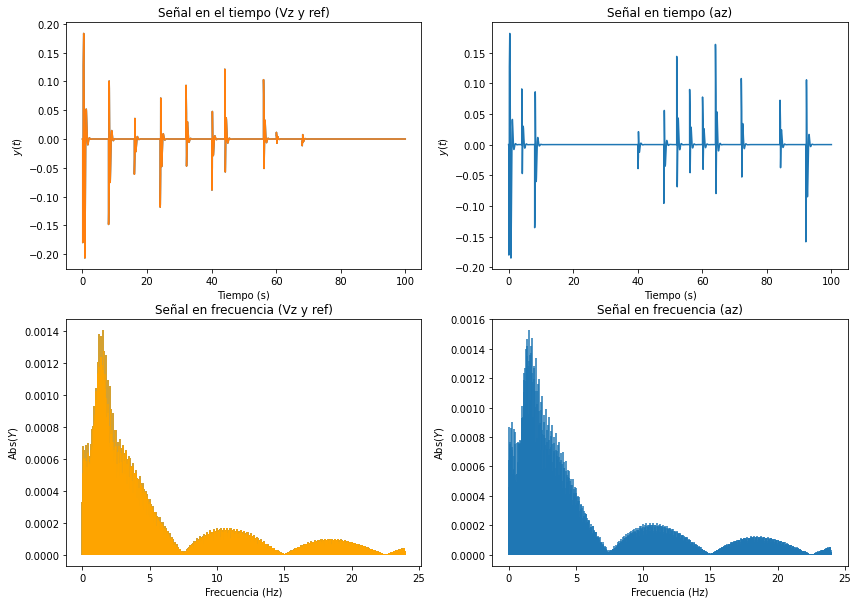

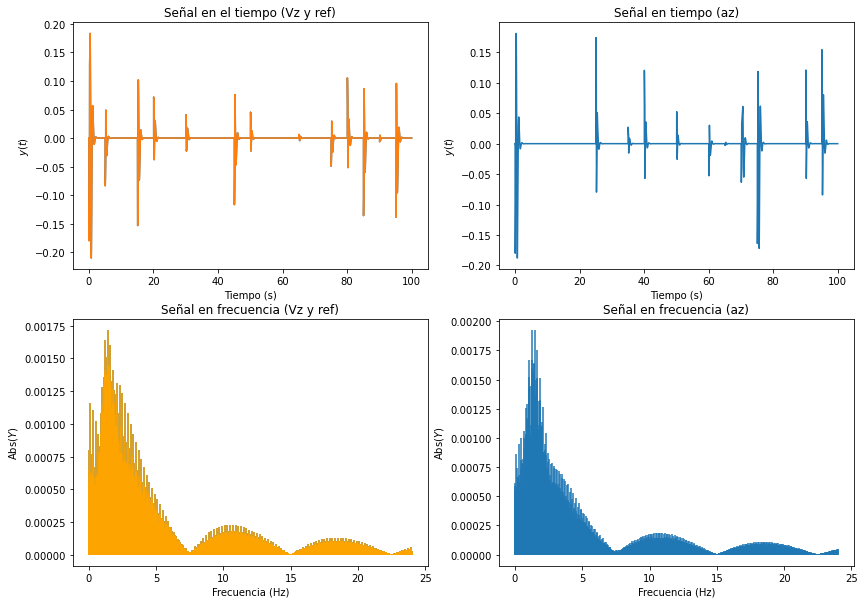

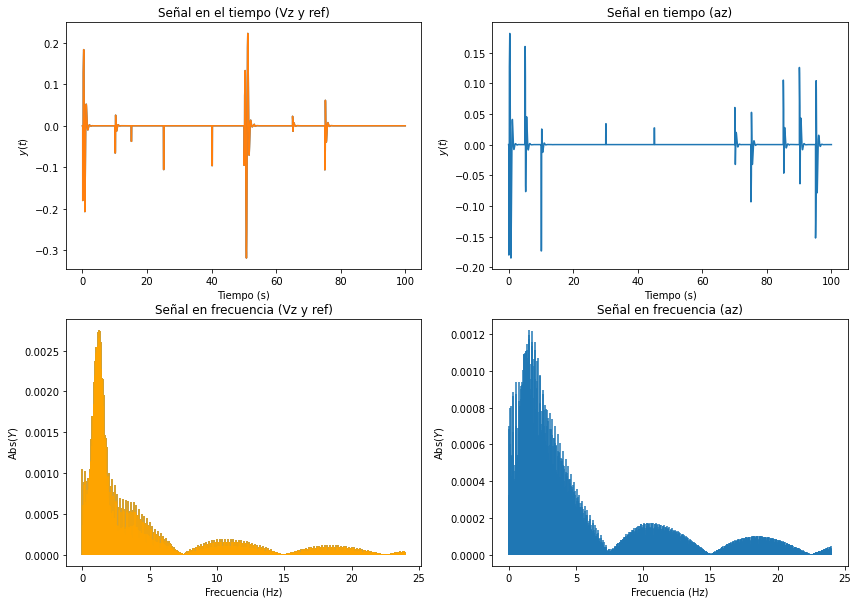

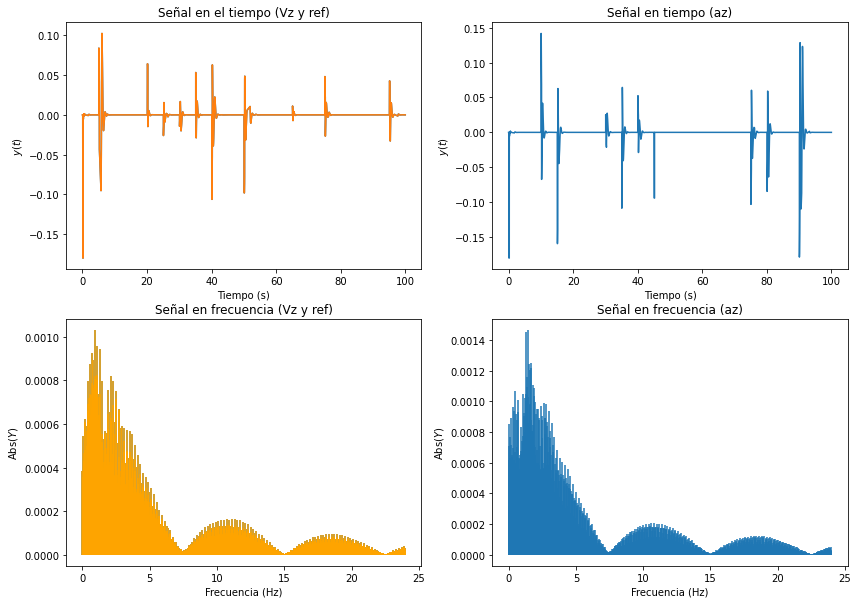

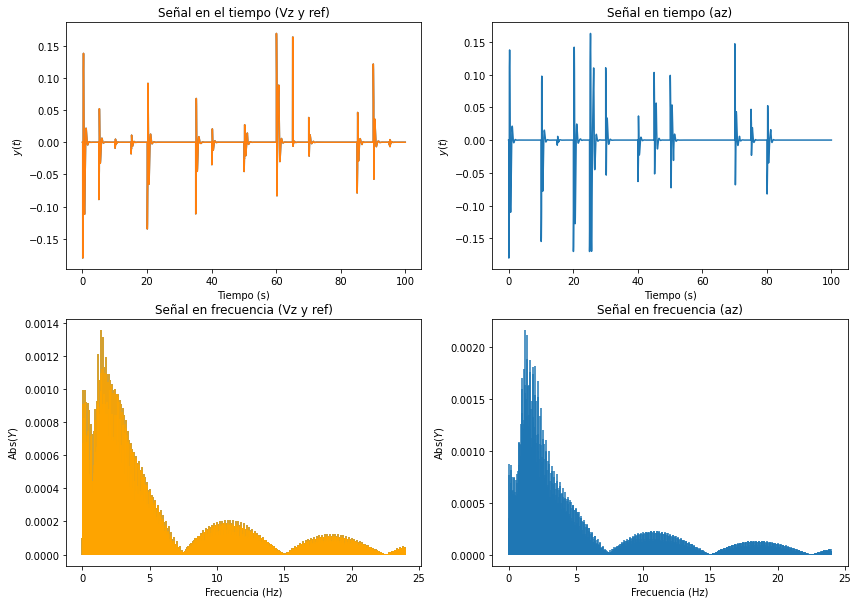

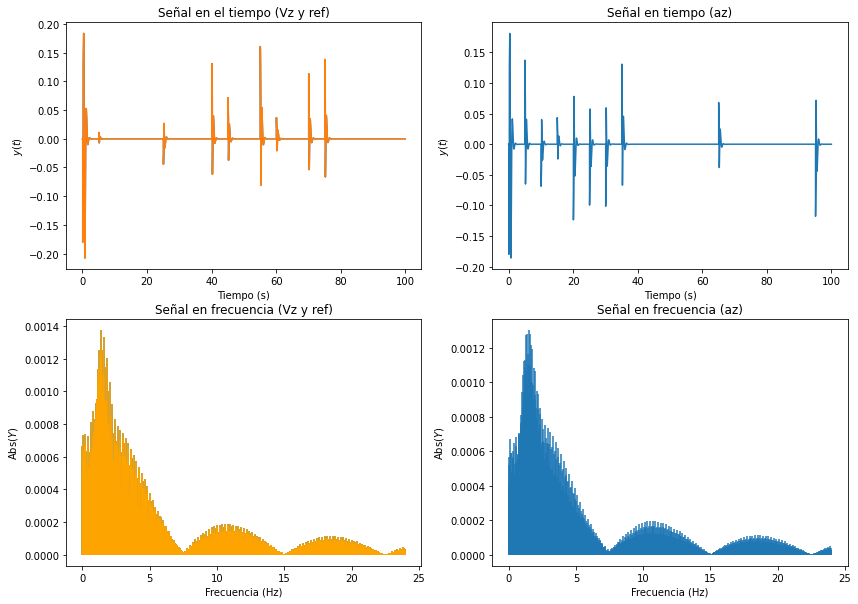

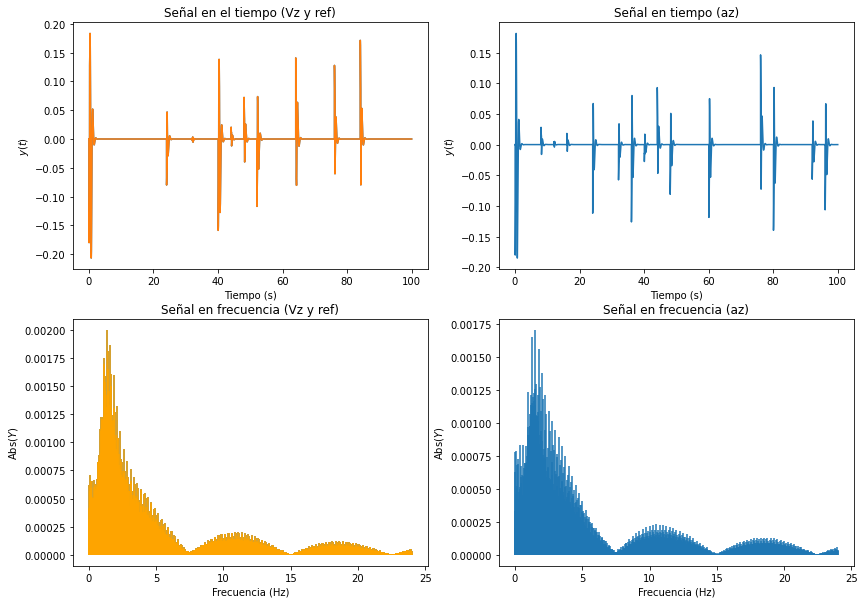

In [15]:
for df in random.choices(dfs, k = 8):
    plot_fourier(df, states=['p', 'p', 'q'])

#### Histograma

In [16]:
Fourier = []
for i, df in enumerate(dfs):
    dt = df['timestamps'][1]-df['timestamps'][0]
    n = len(df['timestamps'])
    Fourier.append({})
    for state in states_list_org:
        Fourier[i][state]={}
        Fourier[i][state]['Y'] = abs(fft(df[state].to_numpy())/n)[0:int(n/2)] # Transformada normalizada
        Fourier[i][state]['X'] = fftfreq(n, dt)[0:int(n/2)]

In [17]:
F = {}
for state in states_list_org:
    F[state]={}
    F[state]['X'] = []
    F[state]['Y'] = []
    for f in Fourier:
        F[state]['X'] = np.concatenate([F[state]['X'], f[state]['X']]) 
        F[state]['Y'] = np.concatenate([F[state]['Y'], f[state]['Y']]) 

Text(0.5, 0, 'Frecuency [Hz]')

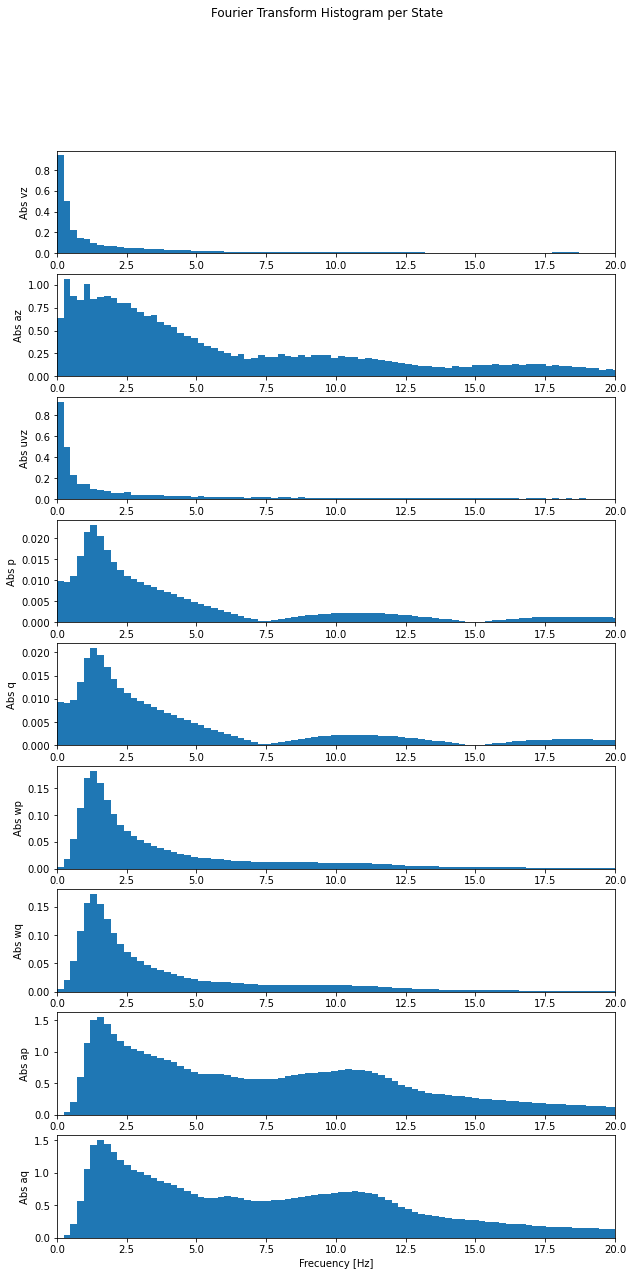

In [18]:
fig, axs = plt.subplots(len(states_list_org), 1, figsize=(10, 20))
fig.suptitle('Fourier Transform Histogram per State')
for i, state in enumerate(states_list_org):
    axs[i].hist(F[state]['X'], bins=10*n_bins, weights=((F[state]['Y']+1e-7)/len(Fourier)))
    axs[i].set_ylabel(f'Abs {state}')
    axs[i].set_xlim(0, 20)
axs[i].set_xlabel('Frecuency [Hz]')

### Análisis de Características - Método Estático

In [19]:
dataset.describe()

,timestamps,x,y,z,Q1,Q2,Q3,Q4,p,q,r,vx,vy,vz,wp,wq,wr,ax,ay,az,ap,aq,ar,RPM0,RPM1,RPM2,RPM3,ux,uy,uz,uvx,uvy,uvz,up,uq,ur,uwp,uwq,uwr,vz1,az1,uvz1,p1,q1,wp1,wq1,ap1,aq1,vz2,az2,uvz2,p2,q2,wp2,wq2,ap2,aq2,vz3,az3,uvz3,p3,q3,wp3,wq3,ap3,aq3
count,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4007833.0,4007833.0,4007833.0,4007833.0,4007833.0,4.007833e+06,4007833.0,4007833.0,4007833.0,4007833.0,4007833.0,4007833.0,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06,4.007833e+06
mean,4.999583e+01,1.232111e-01,-1.129199e-01,5.341394e+01,-1.124056e-04,-1.166851e-04,6.719640e-05,9.999114e-01,-2.303242e-04,-2.300284e-04,1.836237e-04,1.468863e-03,-1.370043e-03,7.058128e-02,6.759972e-05,-6.813699e-05,-4.751161e-05,1.580413e-10,1.229393e-09,3.210177e-04,-4.129174e-08,-1.073950e-09,-1.275564e-09,1.441872e+04,1.441844e+04,1.441873e+04,1.441900e+04,0.0,0.0,50.0,0.0,0.0,5.302769e-02,0.0,0.0,0.0,0.0,0.0,0.0,7.057994e-02,3.228008e-04,5.302917e-02,-2.303242e-04,-2.300284e-04,6.759989e-05,-6.813698e-05,-4.142293e-08,-1.133661e-09,7.057859e-02,3.245846e-04,5.303064e-02,-2.303243e-04,-2.300284e-04,6.760007e-05,-6.813698e-05,-4.155414e-08,-1.193382e-09,7.057724e-02,3.263690e-04,5.303212e-02,-2.303243e-04,-2.300284e-04,6.760024e-05,-6.813697e-05,-4.168538e-08,-1.253112e-09
std,2.886631e+01,8.825598e-02,8.576300e-02,9.609585e+00,9.626432e-03,9.127336e-03,8.662359e-04,6.002488e-04,1.938697e-02,1.821034e-02,2.268712e-03,2.554577e-02,2.691607e-02,8.876363e-01,1.312313e-01,1.266916e-01,1.608981e-02,1.428626e-01,1.522444e-01,1.822109e+00,2.016054e+00,1.990444e+00,6.490893e-01,1.325549e+03,1.328543e+03,1.325717e+03,1.322718e+03,0.0,0.0,0.0,0.0,0.0,9.432127e-01,0.0,0.0,0.0,0.0,0.0,0.0,8.876180e-01,1.822077e+00,9.431880e-01,1.938697e-02,1.821034e-02,1.312313e-01,1.266916e-01,2.016054e+00,1.990444e+00,8.875997e-01,1.822046e+00,9.431632e-01,1.938697e-02,1.821034e-02,1.312313e-01,1.266916e-01,2.016054e+00,1.990444e+00,8.875814e-01,1.822014e+00,9.431385e-01,1.938697e-02,1.821034e-02,1.312313e-01,1.266916e-01,2.016054e+00,1.990444e+00
min,0.000000e+00,-2.047597e-01,-4.811760e-01,2.697847e+01,-1.698321e-01,-1.457588e-01,-4.432610e-02,9.752161e-01,-3.536326e-01,-2.834447e-01,-8.505308e-02,-4.256045e-01,-5.883179e-01,-9.426658e+00,-2.441203e+00,-2.568337e+00,-6.203632e-01,-4.023462e+00,-3.135487e+00,-9.800000e+00,-1.762474e+01,-1.727289e+01,-1.572234e+01,9.440300e+03,9.440300e+03,9.440300e+03,9.440300e+03,0.0,0.0,50.0,0.0,0.0,-9.640079e+00,0.0,0.0,0.0,0.0,0.0,0.0,-9.426658e+00,-9.800000e+00,-9.640079e+00,-3.536326e-01,-2.834447e-01,-2.441203e+00,-2.568337e+00,-1.762474e+01,-1.727289e+01,-9.426658e+00,-9.800000e+00,-9.640079e+00,-3.536326e-01,-2.834447e-01,-2.441203e+00,-2.568337e+00,-1.762474e+01,-1.727289e+01,-9.426658e+00,-9.800000e+00,-9.640079e+00,-3.536326e-01,-2.834447e-01,-2.441203e+00,-2.568337e+00,-1.762474e+01,-1.727289e+01
25%,2.499583e+01,7.730229e-02,-1.592710e-01,5.008806e+01,-3.020625e-08,-2.448411e-08,-5.146146e-07,1.000000e+00,-6.436319e-08,-5.447548e-08,-9.294998e-07,-5.306351e-08,-8.073925e-08,-7.346576e-02,-4.127837e-07,-3.408623e-07,-3.469616e-07,-4.160205e-07,-5.834920e-07,-7.146616e-03,-3.930490e-06,-3.317791e-06,-1.070975e-09,1.442594e+04,1.442414e+04,1.442605e+04,1.442492e+04,0.0,0.0,50.0,0.0,0.0,-7.237447e-02,0.0,0.0,0.0,0.0,0.0,0.0,-7.344996e-02,-7.143027e-03,-7.237447e-02,-6.435992e-08,-5.447285e-08,-4.127670e-07,-3.408300e-07,-3.930290e-06,-3.317570e-06,-7.34

#### Mapa de Correlación

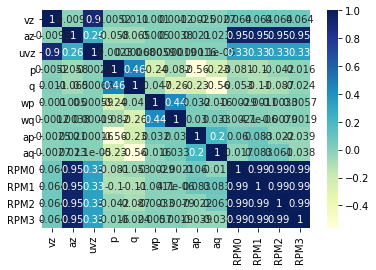

In [20]:
correlation = dataset[states_list_org + rpm_list].corr() #corr() method of pandas library calculates correlation between columns of dataframe
sns.heatmap(correlation,cmap="YlGnBu",annot=True)
plt.show()

#### Análisis de Correlaciones

In [21]:
# Comentado porque se demora mucho procesando
# for i in states_list_org:
#     sns.lmplot(x=i, y=rpm_list[0], data=dataset,line_kws={'color': 'red'})
#     text="Relation between RPM0 and " + i 
#     plt.title(text)
#     plt.show()

In [22]:
corr_df = pd.DataFrame()
for i in rpm_list:
    correlation = dataset.corr()[i] # convert series to dataframe so it can be sorted
    correlation_df = pd.DataFrame(correlation) # correct column label from Points to correlation
    correlation_df.columns = [f"Correlation_{i}"] # sort correlation
    corr_df = pd.concat([correlation_df, corr_df], axis=1)
corr_df = corr_df.dropna(how='all')
corr_df = corr_df.sort_values(by=[f'Correlation_{rpm_list[0]}'], ascending=False)
corr_df.head(30)

,Correlation_RPM3,Correlation_RPM2,Correlation_RPM1,Correlation_RPM0
RPM0,0.991461,0.990278,0.991656,1.000000
RPM1,0.985660,0.991275,1.000000,0.991656
RPM3,1.000000,0.991579,0.985660,0.991461
RPM2,0.991579,1.000000,0.991275,0.990278
az,0.949121,0.950150,0.949392,0.950166
az1,0.922955,0.923834,0.923384,0.923842
az2,0.896776,0.897504,0.897362,0.897505
az3,0.870584,0.871161,0.871328,0.871154
uvz,0.333734,0.332963,0.332300,0.333040
uvz1,0.333448,0.332674,0.332010,0.332752


### Análisis de Características - Método Dinámico

#### Autocorrelación Parcial

In [23]:
# N_df = 3
# nlags = 15
# fig, axs = plt.subplots(N_df, len(states_list_min), figsize=(15, 15))
# for k, df in enumerate(random.choices(dfs, k = N_df)):
#     for j, i in enumerate(states_list_min):
#         plot_pacf(df[i], lags=nlags, ax = axs[j, k])
#         axs[j, k].set_title(i)

In [24]:
# pacf_df = [pd.DataFrame()]*len(states_list_min)
# for k, df in enumerate(dfs):
#     for j, i in enumerate(states_list_min):
#         tmp = pd.DataFrame(pacf(df[i], nlags=nlags), columns=[str(k)])
#         pacf_df[j] = pd.concat([pacf_df[j], tmp], axis=1)
# pacf_df_dict = {}
# for j, i in enumerate(states_list_min):
#     pacf_df_dict[i] =  pd.DataFrame()
#     pacf_df_dict[i]['mean'] = pacf_df[j].T.mean()
#     pacf_df_dict[i]['min'] = pacf_df[j].T.min()
#     pacf_df_dict[i]['max'] = pacf_df[j].T.max()
#     pacf_df_dict[i]['abs'] = np.maximum(pacf_df[j].T.max(), abs(pacf_df[j].T.min()))

In [25]:
# fig, axes = plt.subplots(nrows=len(states_list_min), ncols=1, figsize=(10, 10))
# crt = 'mean'
# for j, i in enumerate(states_list_min):
#     pacf_df_dict[i][crt].plot(kind="bar", ax=axes[j])
#     axes[j].set_ylabel('Autocorrelación')
#     axes[j].set_title(f'Autocorrelación_{i}_{crt}')

In [26]:
# fig, axes = plt.subplots(nrows=len(states_list_min), ncols=1, figsize=(10, 10))
# crt = 'abs'
# for j, i in enumerate(states_list_min):
#     pacf_df_dict[i][crt].plot(kind="bar", ax=axes[j])
#     axes[j].set_ylabel('Autocorrelación')
#     axes[j].set_title(f'Autocorrelación_{i}_{crt}')